# Test Frame Loading and Crop Box Generation

This notebook tests loading frame data using torch.load and generating crop_box using get_bbox_from_verts method.

In [11]:
import torch
import numpy as np
import sys
import os

# Add current directory to path to import modules
sys.path.append('/root/autodl-tmp/cap4d')

from cap4d.flame.flame import CAP4DFlameSkinner
from cap4d.datasets.utils import (
    load_flame_verts_and_cam,
    get_bbox_from_verts,
)

In [12]:
# Load frame data using torch.load
frame_path = '/root/autodl-tmp/pixel3dmm/data/tracking_output/grandma_nV1_noPho_noMICA_FLAME23_uv2000.0_n1000.0/checkpoint/00000.frame'
frame_data = torch.load(frame_path, weights_only=False)  # Set weights_only=False for compatibility

print("Frame data keys:", list(frame_data.keys()))
print("\nFlame keys:", list(frame_data['flame'].keys()))
print("\nCamera keys:", list(frame_data['camera'].keys()))

Frame data keys: ['flame', 'img_size', 'frame_id', 'global_step', 'camera', 'joint_transforms']

Flame keys: ['exp', 'shape', 'eyes', 'eyelids', 'jaw', 'neck', 'R', 'R_rotation_matrix', 't']

Camera keys: ['R_base_0', 't_base_0', 'fl', 'pp']


In [13]:
# Initialize FLAME skinner (same as in the original code)
flame_skinner = CAP4DFlameSkinner(
    add_mouth=True, 
    n_shape_params=150,
    n_expr_params=65,
)

# Load head vertex IDs
head_vertex_ids = np.genfromtxt("/root/autodl-tmp/cap4d/data/assets/flame/head_vertices.txt").astype(int)

print("FLAME skinner initialized")
print(f"Head vertex IDs shape: {head_vertex_ids.shape}")

FLAME skinner initialized
Head vertex IDs shape: (4783,)


In [14]:
# Extract FLAME parameters and camera info from loaded frame
flame_params = frame_data['flame']
camera_params = frame_data['camera']

print("FLAME parameters:")
for key, value in flame_params.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    else:
        print(f"  {key}: {value}")

print("\nCamera parameters:")
for key, value in camera_params.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: shape {value.shape}, dtype {value.dtype}")
    else:
        print(f"  {key}: {type(value)}")

# Check FLAME skinner expected dimensions
print(f"\nFLAME skinner expected dimensions:")
print(f"  n_shape_params: {flame_skinner.n_shape_params}")
print(f"  n_expr_params: {flame_skinner.n_expr_params}")

FLAME parameters:
  exp: shape (1, 65), dtype float32
  shape: shape (1, 150), dtype float32
  eyes: shape (1, 12), dtype float32
  eyelids: shape (1, 2), dtype float32
  jaw: shape (1, 6), dtype float32
  neck: shape (1, 6), dtype float32
  R: shape (1, 6), dtype float32
  R_rotation_matrix: shape (1, 3, 3), dtype float32
  t: shape (1, 3), dtype float32

Camera parameters:
  R_base_0: shape (1, 3, 3), dtype float32
  t_base_0: shape (1, 3), dtype float32
  fl: shape (1, 1), dtype float32
  pp: shape (1, 2), dtype float32

FLAME skinner expected dimensions:
  n_shape_params: 150
  n_expr_params: 65


In [15]:
import torch
import torch.nn.functional as F

def rotation_6d_to_matrix(d6: torch.Tensor) -> torch.Tensor:
    """
    Converts 6D rotation representation by Zhou et al. [1] to rotation matrix
    using Gram--Schmidt orthogonalization per Section B of [1].
    Args:
        d6: 6D rotation representation, of size (*, 6)

    Returns:
        batch of rotation matrices of size (*, 3, 3)

    [1] Zhou, Y., Barnes, C., Lu, J., Yang, J., & Li, H.
    On the Continuity of Rotation Representations in Neural Networks.
    IEEE Conference on Computer Vision and Pattern Recognition, 2019.
    Retrieved from http://arxiv.org/abs/1812.07035
    """

    a1, a2 = d6[..., :3], d6[..., 3:]
    b1 = F.normalize(a1, dim=-1)
    b2 = a2 - (b1 * a2).sum(-1, keepdim=True) * b1
    b2 = F.normalize(b2, dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    return torch.stack((b1, b2, b3), dim=-2)
# Create flame_item dict with the loaded parameters
# Remove batch dimension [1, ...] -> [...] and map frame parameters to compute_flame expected parameters
ext = np.eye(4)
ext[:3, :3] = camera_params['R_base_0'][0]
ext[:3, 3] = camera_params['t_base_0'][0]
ext[3, 3] = 1
img_size = 512
fx = camera_params['fl'][0] * img_size  # 转换为像素坐标
fy = camera_params['fl'][0] * img_size

cx = img_size / 2+0.5 + camera_params['pp'][0][0] * (img_size/2+0.5)
cy = img_size / 2+0.5 + camera_params['pp'][0][1] * (img_size/2+0.5)
flame_item = {
    'expr': flame_params['exp'],  # Remove batch dim: [1, 65] -> [65]
    'shape': flame_params['shape'][0],  # Remove batch dim: [1, 150] -> [150]  
    'rot': flame_params['R_rotation_matrix'][0][None,...],     # Remove batch dim: [1, 6] -> [6]
    'tra': flame_params['t'][0],     # Remove batch dim: [1, 3] -> [3]
    'eye_rot': rotation_6d_to_matrix(torch.from_numpy(flame_params['eyes'][0][:6]))[None,...].numpy(),  # Remove batch dim: [1, 12] -> [12]
    'jaw_rot': rotation_6d_to_matrix(torch.from_numpy(flame_params['jaw'][0][:6]))[None,...].numpy(),   # Remove batch dim: [1, 6] -> [6]
    'neck_rot': rotation_6d_to_matrix(torch.from_numpy(flame_params['neck'][0]))[None,...].numpy(), # Remove batch dim: [1, 6] -> [6]
    # Camera parameters - also remove batch dimensions
    'fx': fx[None,...],  # [1, 1] -> [1] -> take first element for fx
    'fy': fy[None,...],  # Using same focal length for both fx and fy
    'cx': np.array([cx])[None,...],  # [1, 2] -> [2] -> take x component
    'cy': np.array([cy])[None,...],  # [1, 2] -> [2] -> take y component  
    'extr': ext[None,...], # Remove batch dim: [1, 3, 3] -> [3, 3]
    'timestep_id': frame_data.get('frame_id', 0)
}

print("Created flame_item with keys:", list(flame_item.keys()))
print("Parameter shapes after removing batch dimension:")
for key, value in flame_item.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {type(value)}")

Created flame_item with keys: ['expr', 'shape', 'rot', 'tra', 'eye_rot', 'jaw_rot', 'neck_rot', 'fx', 'fy', 'cx', 'cy', 'extr', 'timestep_id']
Parameter shapes after removing batch dimension:
  expr: [[ 0.7064885   0.30107093 -0.13355576  0.19018938  0.3432164   0.43299046
   0.21728654  0.3408363   0.76360726 -0.33076504 -0.09755613 -0.30009416
   0.22666694  0.62792873 -0.28871217  0.25783417 -0.3840535   0.03137099
   0.3857069   0.66421014 -0.16170219  0.36864495  0.23834854 -0.31083205
   0.26116046  0.22938888 -0.4123108  -0.47692597 -0.38512623  0.76380193
   0.3269895   0.1822809  -0.3443286   0.22985247 -0.3360157   0.10444111
   0.26700664  0.06783793 -0.4698114  -0.721265   -0.16189975 -0.02283118
  -0.21593039 -0.2173928  -0.02703053  0.52167106  0.12324687  0.3848441
   0.59412336 -0.12460209 -0.6412446  -0.25546998  0.12851602  0.42126396
   0.4961716   0.40399975 -0.47650903  0.43394187  0.41451523  0.0985622
   0.18357326 -0.48539472  0.49114996  0.63987684  0.7807274 ]

In [16]:
# Use the flame parameters to get vertices and camera info

verts_2d, offsets_3d, intrinsics, extrinsics = load_flame_verts_and_cam(
    flame_skinner,
    flame_item,
)
print("Successfully loaded FLAME vertices and camera parameters")
print(f"verts_2d shape: {verts_2d.shape}")
print(f"offsets_3d shape: {offsets_3d.shape}")
print(f"intrinsics shape: {intrinsics}")
print(f"extrinsics shape: {extrinsics}")

Successfully loaded FLAME vertices and camera parameters
verts_2d shape: (5223, 3)
offsets_3d shape: (5223, 3)
intrinsics shape: [[1.79298608e+03 0.00000000e+00 2.56513607e+02]
 [0.00000000e+00 1.79298608e+03 2.56417505e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
extrinsics shape: [[ 1. -0.  0.  0.]
 [ 0.  1.  0.  0.]
 [-0. -0.  1. -1.]
 [ 0.  0.  0.  1.]]


In [17]:
# Generate crop_box using get_bbox_from_verts
try:
    crop_box = get_bbox_from_verts(verts_2d, head_vertex_ids)
    print("Successfully generated crop_box")
    print(f"Crop box: {crop_box}")
    print(f"Crop box type: {type(crop_box)}")
    if hasattr(crop_box, 'shape'):
        print(f"Crop box shape: {crop_box.shape}")
except Exception as e:
    print(f"Error generating crop_box: {e}")
    import traceback
    traceback.print_exc()

(-18, 12, 530, 560)
Successfully generated crop_box
Crop box: [-18  12 530 560]
Crop box type: <class 'numpy.ndarray'>
Crop box shape: (4,)


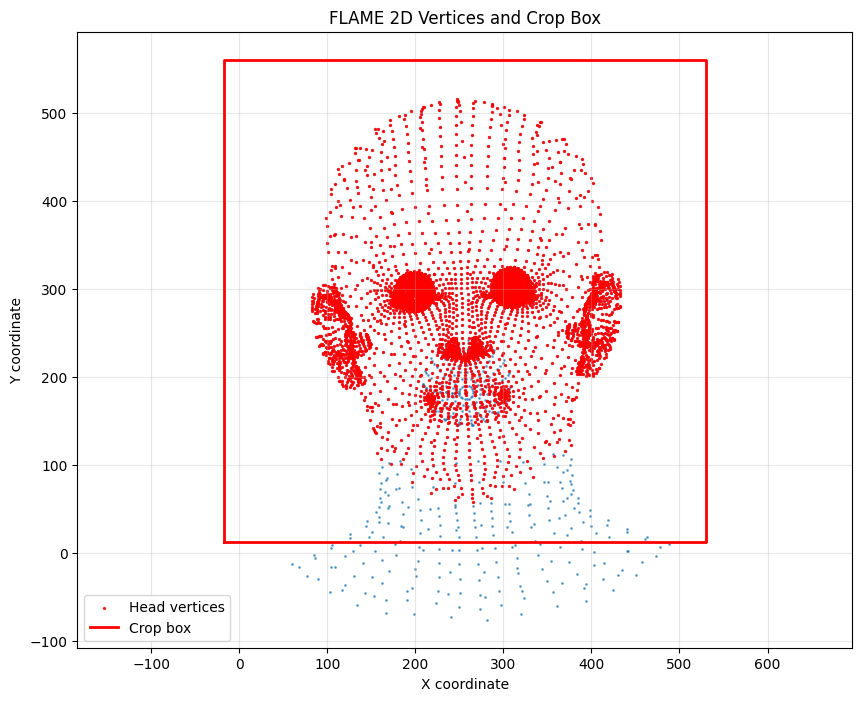

In [18]:
# Visualize some of the 2D vertices
import matplotlib.pyplot as plt

if 'verts_2d' in locals():
    plt.figure(figsize=(10, 8))
    plt.scatter(verts_2d[:, 0], verts_2d[:, 1], s=1, alpha=0.6)
    
    # Highlight head vertices
    head_verts = verts_2d[head_vertex_ids]
    plt.scatter(head_verts[:, 0], head_verts[:, 1], s=2, color='red', alpha=0.8, label='Head vertices')
    
    # Draw crop box if available
    if 'crop_box' in locals():
        x1, y1, x2, y2 = crop_box
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r-', linewidth=2, label='Crop box')
    
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('FLAME 2D Vertices and Crop Box')
    plt.legend()
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("verts_2d not available for visualization")